#**Trabajo Práctico N°1: Reservas de Hotel**
Organización de Datos (7506): cátedra Rodriguez

Grupo 25:
- Mariana Juarez Goldemberg - Padrón: 108441
- Lisandro Roman - Padrón: 107274
- Miranda Marenzi - Padrón: 109404

Checkpoint N°2


Clasificación - Entrenamiento y Predicción

El objetivo será predecir el valor del atributo is_canceled, los modelos deberán entrenarse con
los datos de train y se deberán realizar las tareas de ingeniería de características necesarias
para trabajar con cada algoritmo (encoding, normalización, balanceo, etc)

Checkpoint 2 : Árbol de decisión

a. Construir árboles de decisión y optimizar sus hiperparámetros mediante k-fold
Cross Validation para obtener la mejor performance. ¿Cuántos folds utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

b. Graficar el árbol de decisión con mejor performance encontrado en el punto
anterior. Si es muy extenso mostrar una porción representativa.

c. Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y
decisiones evaluadas (explicar las primeras reglas obtenidas).

d. Evaluar la performance del modelo en entrenamiento y validación, explicar todas
las métricas y mostrar la matriz de confusión.

e. Generar predicciones con el conjunto de test y realizar los submits
correspondientes en la competencia de Kaggle.

#Árbol de decisión

In [ ]:
!pip install 'dtreeviz'

Importamos las librerías que necesitaremos a lo largo del trabajo.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer,f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import sklearn as sk

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

Cargamos el dataframe y le realizamos una copia para trabajar sin modficar el original. El dataframe con el que trabajamos es el que quedó del Checkpoint N°1 (con unas modificaciones que fueron agregadas a la entrega).

In [ ]:
df_check1 = pd.read_csv('/content/sample_data/df.csv')
df_test_check1 = pd.read_csv('/content/sample_data/df_test.csv')


Defino features y el target.

In [ ]:
features = ['lead_time',
'arrival_date_year',
'arrival_date_month',
'arrival_date_day_of_month',
'stays_in_weekend_nights',
'stays_in_week_nights',
'adults',
'children',
'babies',
'is_repeated_guest',
'previous_cancellations',
'previous_bookings_not_canceled',
'reserved_room_type',
'assigned_room_type',
'booking_changes',
'agent',
'company',
'days_in_waiting_list',
'adr' ,
'required_car_parking_spaces',
'total_of_special_requests',
'customer_type_Group',
'customer_type_Transient'      ,
'customer_type_Transient-Party',
'deposit_type_Non Refund'      ,
'deposit_type_Refundable'     ,
'meal_FB'    ,
'meal_HB'    ,
'meal_SC'    ,
'meal_Undefined'     ,
'hotel_Resort Hotel' ,
'market_segment_Complementary' ,
'market_segment_Corporate'     ,
'market_segment_Direct'        ,
'market_segment_Groups'        ,
'market_segment_Offline TA/TO',
'market_segment_Online TA',
'distribution_channel_Direct'  ,
'distribution_channel_GDS'     ,
'distribution_channel_TA/TO'   ,
'continent_America'  ,
'continent_Asia'     ,
'continent_Europa'   ,
'continent_Oceania'  ,
'estadia_completa_o_reservado' ]

In [ ]:
target = ["is_canceled"]

Creamos el set de evaluación.

In [ ]:
df_train = df_check1.copy()
df_test = df_test_check1.copy()
df_trabajo_x=df_train.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_train['is_canceled'].copy()
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=9)

In [ ]:
df_test.drop(columns = ['reservation_status_date'], inplace = True)

In [ ]:
tree_model = tree.DecisionTreeClassifier(max_depth = 7)
model = tree_model.fit(X = x_train, y = y_train)

##Primera predicción

Para estudiar y realizar la optimización de los parámetros del árbol de decisión decidimos utilizar Random Search ya que nos resultó más rápido en cuestión de ejecución y además notamos que hay cambios que se ven más explícitos a la hora de hacer las n combinaciones.

Probamos con diferentes K-Folds y con las cuales las métricas alcanzan su punto máximo.

In [ ]:
def parametros_optimizados_prueba(df_train_x, df_train_y, it, cant_folds):
    n= it
    folds= cant_folds
    parametros_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.05,n),
               'max_depth':list(range(1,6))}
    kfoldcv = StratifiedKFold(n_splits=folds)
    arbol_base = DecisionTreeClassifier()
    scorer_fn = make_scorer(f1_score, average='micro')

    randomcv = RandomizedSearchCV(estimator=arbol_base,
                                param_distributions = parametros_grid,
                                scoring=scorer_fn,
                                cv=kfoldcv,
                                n_iter=n,
                                random_state=1)


    return randomcv.fit(df_train_x,df_train_y)

randomcv_prueba = parametros_optimizados_prueba(x_train, y_train, 20, 10)

In [ ]:
print(str(randomcv_prueba.best_params_))
print(str(randomcv_prueba.best_score_))


{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 4, 'criterion': 'entropy', 'ccp_alpha': 0.010526315789473684}
0.7158668400054464


In [ ]:
arbol_prueba=DecisionTreeClassifier().set_params(**randomcv_prueba.best_params_)

In [ ]:
arbol_prueba.fit(x_train,y_train)

reglas = export_text(arbol_prueba, feature_names=list(features))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 8.50
|   |   |   |--- class: 0
|   |   |--- lead_time >  8.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- market_segment_Online TA >  0.50
|   |   |   |   |--- class: 1
|   |--- required_car_parking_spaces >  0.50
|   |   |--- class: 0
|--- deposit_type_Non Refund >  0.50
|   |--- class: 1



In [ ]:
y_pred = arbol_prueba.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='micro')))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      8646
           1       0.69      0.77      0.73      8544

    accuracy                           0.72     17190
   macro avg       0.72      0.72      0.72     17190
weighted avg       0.72      0.72      0.72     17190

F1-Score: 0.7165794066317627


###Predicción sobre el verdadero archivo de test

In [ ]:
df_id = pd.read_csv('/content/sample_data/df_test_id.csv')

In [ ]:
y_pred = arbol_prueba.predict(df_test)

In [ ]:
ds_resultados=pd.DataFrame(zip(df_id['id'],y_pred),columns=['id','is_canceled'])
ds_resultados.head(5)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [ ]:
ds_resultados.to_csv("prediccion1_hotel.csv", index = False)

##Segunda predicción

Podemos encontrar un mejor F Score, para esto, aumentaremos la cantidad de folds. Al aumentar los folds proporciona una evaluación más robusta del modelo, ya que se prueban en diferentes subconjuntos de datos. Creemos que esto también produciría una búsqueda de hiperparámetros más efectiva.

También realizaremos más iteraciones del algoritmo, a cambio de un costo mayor de complejidad computacional, y ampliaremos el rango para algún parámetro:

*min_samples_split: número mínimo de muestras que se requieren en un nodo antes de que se pueda dividir en nodos hijos adicionales

*min_samples_leaf:número mínimo de muestras que se requieren en un nodo hoja

*max_depth: establece un límite en la profundidad del árbol

Para este caso, se amplió el rango para min_samples_split

In [ ]:
def parametros_optimizados_final(df_train_x, df_train_y, it, cant_folds):
    n= it
    folds= cant_folds
    parametros_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n),
                'max_depth':list(range(5,6))}
    kfoldcv = StratifiedKFold(n_splits=folds)
    arbol_base = DecisionTreeClassifier()
    scorer_fn = make_scorer(f1_score, average='micro')

    randomcv = RandomizedSearchCV(estimator=arbol_base,
                                param_distributions = parametros_grid,
                                scoring=scorer_fn,
                                cv=kfoldcv,
                                n_iter=n,
                                random_state=1)


    return randomcv.fit(df_train_x,df_train_y)

randomcv_final = parametros_optimizados_final(x_train, y_train, 20, 20)

In [ ]:
print(str(randomcv_final.best_params_))
print(str(randomcv_final.best_score_))

{'min_samples_split': 15, 'min_samples_leaf': 3, 'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.0012105263157894737}
0.7613950915333799


In [ ]:
randomcv_final.cv_results_['mean_test_score']

array([0.76047249, 0.76139509, 0.7607219 , 0.76047249, 0.75643343,
       0.7607219 , 0.76047249, 0.76139509, 0.75643343, 0.7607219 ,
       0.76047249, 0.76047249, 0.7607219 , 0.76047249, 0.75653318,
       0.76139509, 0.76099613, 0.7607219 , 0.76129534, 0.75643343])

Podemos ver los resultados del score promedio para los folds  de cada iteracion, al tener poca varianza, se ve que al cambiar de splits no se altera la prediccion y entonces tenemos un dataset con datos homogeneos.

Veamos los atributos considerados y su importancia

In [ ]:
best_tree = randomcv_final.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

booking_changes: 0.004664712756122712
arrival_date_year: 0.005036121837664281
customer_type_Transient-Party: 0.006955911220491152
market_segment_Online TA: 0.0827594282668744
total_of_special_requests: 0.08397016917199462
lead_time: 0.09323405292551644
previous_cancellations: 0.09517252608178468
required_car_parking_spaces: 0.10945993523250235
deposit_type_Non Refund: 0.5187471425070496


Construimos el árbol utilizando los mejores parámetros.

In [ ]:
arbol=DecisionTreeClassifier().set_params(**randomcv_final.best_params_)

Lo entrenamos e imprimimos sus reglas.

In [ ]:
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(features))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 8.50
|   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |--- booking_changes <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- booking_changes >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |--- class: 1
|   |   |--- lead_time >  8.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- market_segment_Online TA >  0.50
|   |   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- total_of_special_requests >  0.50
|   |   |   |   |   |--- class: 0
|   |--- required_car_parking_spaces >  0.50
|   |   |--- class: 0
|--- deposit_type_Non Refund >  0.50
|   |--- customer_

In [ ]:
y_pred = arbol.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='micro')))

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      8646
           1       0.88      0.60      0.71      8544

    accuracy                           0.76     17190
   macro avg       0.79      0.76      0.75     17190
weighted avg       0.79      0.76      0.75     17190

F1-Score: 0.7607911576497964


Observamos un accuracy (exactitud) del 0.76% apróximadamente.

###Predicción sobre el verdadero archivo de test



In [ ]:
y_pred = arbol.predict(df_test)

In [ ]:
ds_resultados=pd.DataFrame(zip(df_id['id'],y_pred),columns=['id','is_canceled'])
ds_resultados.head(5)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [ ]:
ds_resultados.to_csv("prediccion2_hotel.csv", index = False)

##Tercera predicción

Para este segundo intento de encontrar una mejor predicción, lo que hicimos fue ampliar el rango de los parámetros y aumentar el número de iteraciones, a cambio de una alta complejidad computacional y temporal, obtenemos probar para una gran cantidad de combinaciones cuál es el mejor conjunto de parámetro.
Adjuntamos imagen de los resultados obtenidos para evitar tiempos de ejecución

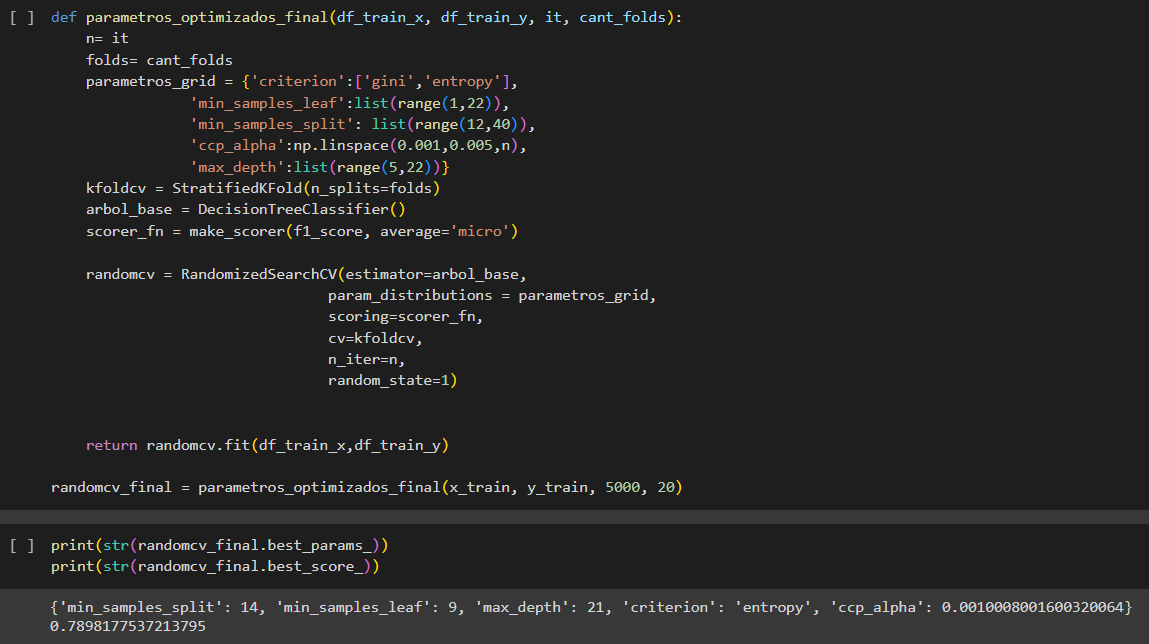

Realizamos la predicción con los susodichos parámetros

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=9)

tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 21, min_samples_split = 14, min_samples_leaf = 9, ccp_alpha = 0.001)
model = tree_model.fit(X = x_train, y = y_train)

In [ ]:
reglas = export_text(tree_model, feature_names=list(features))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 8.50
|   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |--- booking_changes <= 0.50
|   |   |   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- total_of_special_requests >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- booking_changes >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |--- class: 1
|   |   |--- lead_time >  8.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |   |   |--- booking_changes <= 0.50
|   |   |   |   |   |   |   |--- assigned_room_type <= 0.50
|   |   |   |   |   |   |   |   |--- customer_type_Transient-Party <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |

In [ ]:
feat_imps = tree_model.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

meal_Undefined: 0.0022289331480228303
previous_bookings_not_canceled: 0.0031641451134654303
market_segment_Offline TA/TO: 0.0037924435834912717
continent_Europa: 0.00581984223046952
arrival_date_year: 0.008108806864479432
assigned_room_type: 0.009740979015921788
reserved_room_type: 0.009765649191836399
customer_type_Transient: 0.015161773656537439
booking_changes: 0.015405364677911653
customer_type_Transient-Party: 0.026327347319058367
agent: 0.04524797953853196
market_segment_Online TA: 0.06839509261867559
total_of_special_requests: 0.08545261946952734
lead_time: 0.08556721338336337
required_car_parking_spaces: 0.0904612630251557
previous_cancellations: 0.0966509777471062
deposit_type_Non Refund: 0.42870956941644583


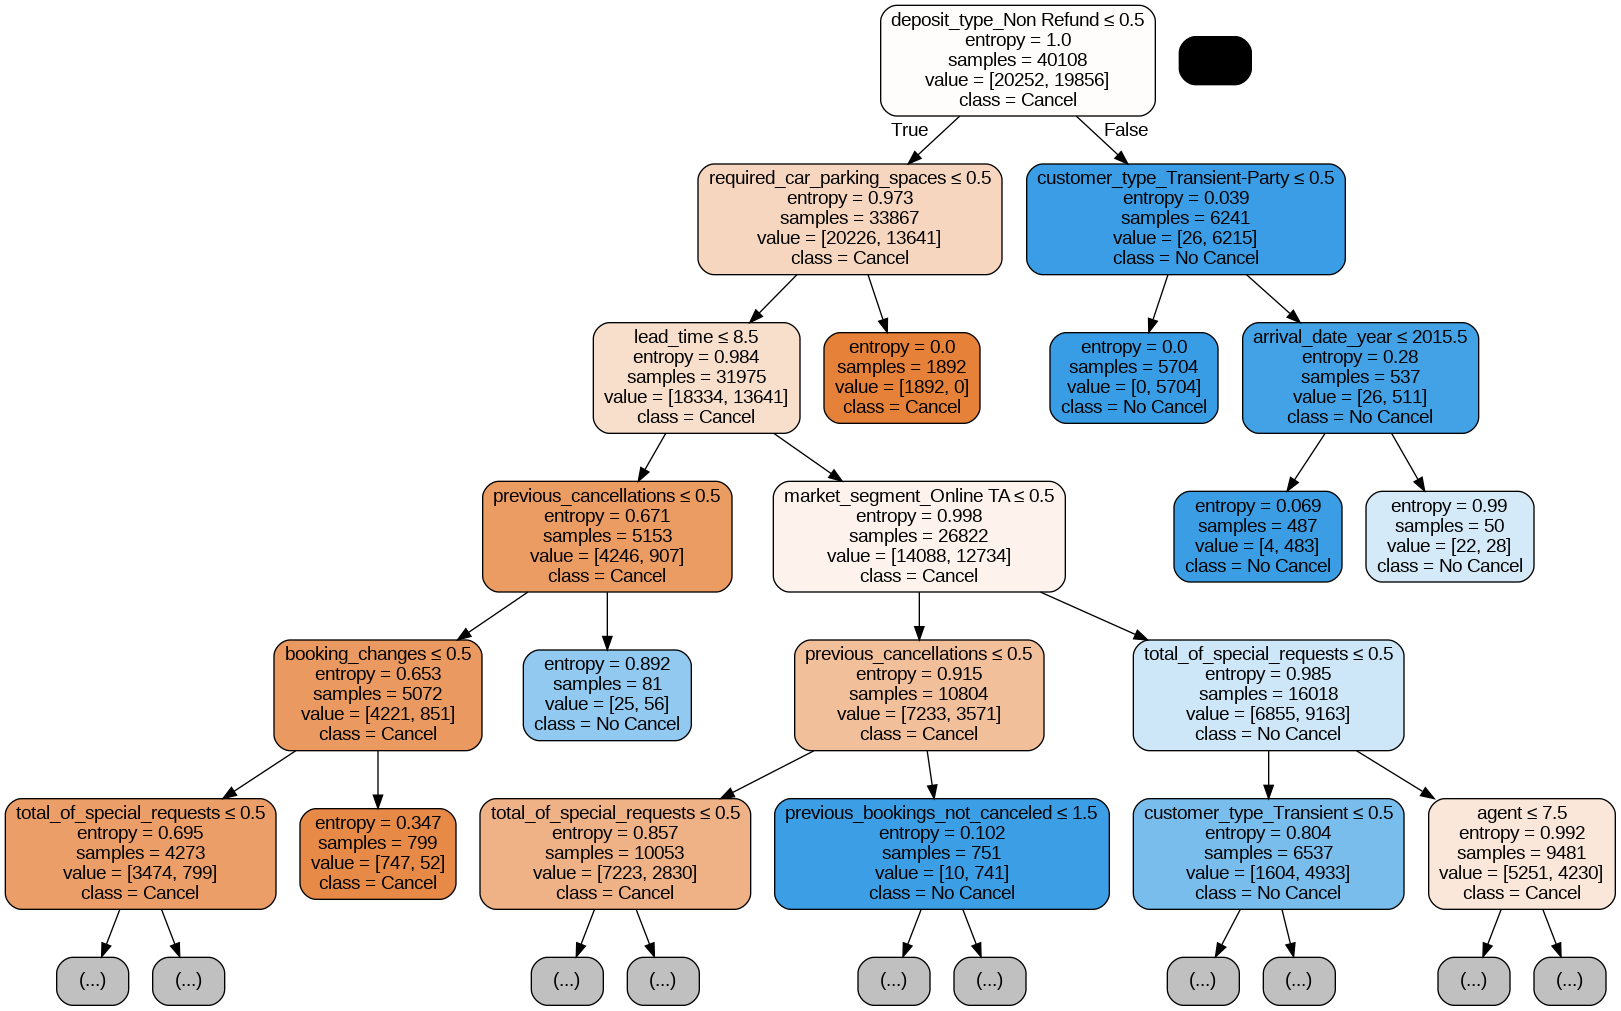

In [ ]:
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['Cancel','No Cancel'],
                max_depth=5)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Analizamos el árbol graficado anteriormente:
Si observamos el nodo raíz, vemos que toma la decisión en base a si hizo o no un depósito correspondiente al valor de costo total de la estadía. Esto quiere decir que si NO se realizó este depósito, la reserva tiende a ser cancelada. Vemos que tiene sentido, el nodo raíz de un árbol de decisión basado en entropía proporciona información sobre cuál es la característica más importante para la primera división y cómo se relaciona con la variable objetivo que buscamos predecir.

Una vez que se bifurca ese nodo, vemos que lo que categoriza como reserva cancelada es una reserva que no tiene requerimientos de cochera, lo cual tiene sentido, se puede considerar la falta de opciones alternativas en algunas áreas o ciudades, entonces encontrar estacionamiento seguro y asequible puede ser complicado.

Por otra parte, luego, la otra variable que tiende a no cancelar una reserva son aquellos que son clientes Transient-Party, y este tiene entropía muy baja. Un nodo con entropía baja indica que las muestras en ese nodo tienden a pertenecer a una sola clase.

La entropía puede tomar valores en el rango de 0 a log₂(n), donde "n" es el número de clases o valores diferentes que puede tomar la variable objetivo en un conjunto de datos.
La entropía puede variar entre 0 (mínima incertidumbre, máxima pureza) y log₂(n) (máxima incertidumbre, máxima impureza), dependiendo de la distribución de clases en el conjunto de datos.
En este caso, la máxima incertidumbre es de aproximadamente 5,49 por lo que el árbol va difurcando en variables que tienen una entropía baja y por lo tanto son importantes para realizar la predicción.

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      8646
           1       0.82      0.73      0.77      8544

    accuracy                           0.78     17190
   macro avg       0.79      0.78      0.78     17190
weighted avg       0.79      0.78      0.78     17190

F1-Score: 0.7842931937172775


Text(50.722222222222214, 0.5, 'True')

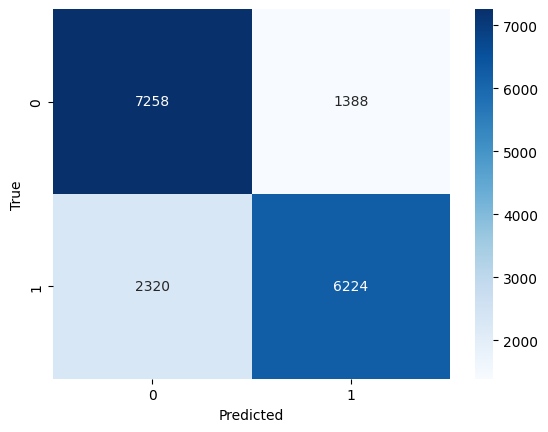

In [ ]:
y_pred = tree_model.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='micro')))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Creemos que es importante evaluar nuestro modelo con f1 score, puesto a que hay que tener en cuenta en funcionamiento de todas las categorías. Veamos qué nos dice la matriz de confusión y la importancia de cada categoría:

Encontramos un total de:

*   Verdaderos negativos hay 7258 casos. Las predicciones acerca de las reservas no canceladas hay un total de 7258 predicciones acertadas.
*   Verdaderos positivos hay 6224 casos. Estos son los casos en los que el modelo predice correctamente que una reserva es cancelada.
* Falsos positivos hay 1388 casos. Estos son los casos en los que el modelo predice incorrectamente que una reserva se cancelará cuando, en realidad, no se cancela.
* Falsos negativos hay 2320 casos. Estos son los casos en los que el modelo predice incorrectamente que una reserva no se cancelará cuando, de hecho, se cancela.

Maximizar los verdaderos negativos y positivos es importante. Tener esta información es muy útil para el hotel para poder planificar la asignación de recursos y gestionar sus operaciones de manera eficiente.

Minimizar los falsos positivos y los falsos negativos también es importante. Esto puede llevar a problemas como la sobrerreserva de habitaciones y la pérdida de ingresos para el hotel, ya que se aisgnarían recursos adicionales innecesariamente. Por ejemplo, podría llevar a la falta de disponibilidad de habitaciones cuando los clientes las necesiten.


###Predicción sobre el verdadero archivo de test

In [ ]:
y_pred = tree_model.predict(df_test)

In [ ]:
ds_resultados=pd.DataFrame(zip(df_id['id'],y_pred),columns=['id','is_canceled'])
ds_resultados.head(5)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [ ]:
ds_resultados.to_csv("prediccion3_hotel.csv", index = False)

##Observación acerca de la métrica elegida

En este caso en particular, nos preocupamos por mejorar el f1-score simplemente usando la función para encontrar mejores parámetros. Si nos apoyamos en la teoría, y en el análisis de nuestro dataframe, cobraría más sentido usar la métrica entropy, que es justamente la que escogió nuestra función y con la que hemos hecho las predicciones.

La realidad es que no hay diferencias grandes entre una métrica y la otra.
De la siguiente fuente https://quantdare.com/decision-trees-gini-vs-entropy/ se obtuvo la siguiente información:
* El criterio de Gini es mucho más rápido porque es menos costoso computacionalmente.
* Los resultados obtenidos utilizando el criterio de entropía son ligeramente mejores.

Podemos ver que nuestro conjunto de datos es bastante equilibrado.
Podría pensarse que la entropía es preferible ya que tiende a dar más peso a la igualdad de clases y puede ser más sensible a las diferencias. La entropía tiende a producir árboles ligeramente más equilibrados.

In [ ]:
df_train[target].value_counts(normalize=True)*100

is_canceled
0              50.43457
1              49.56543
dtype: float64

Veamos qué diferencias hay con nuestra mejor predicción, pero cambiando la métrica por gini.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=9)

tree_model = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 21, min_samples_split = 14, min_samples_leaf = 9, ccp_alpha = 0.001)
model = tree_model.fit(X = x_train, y = y_train)

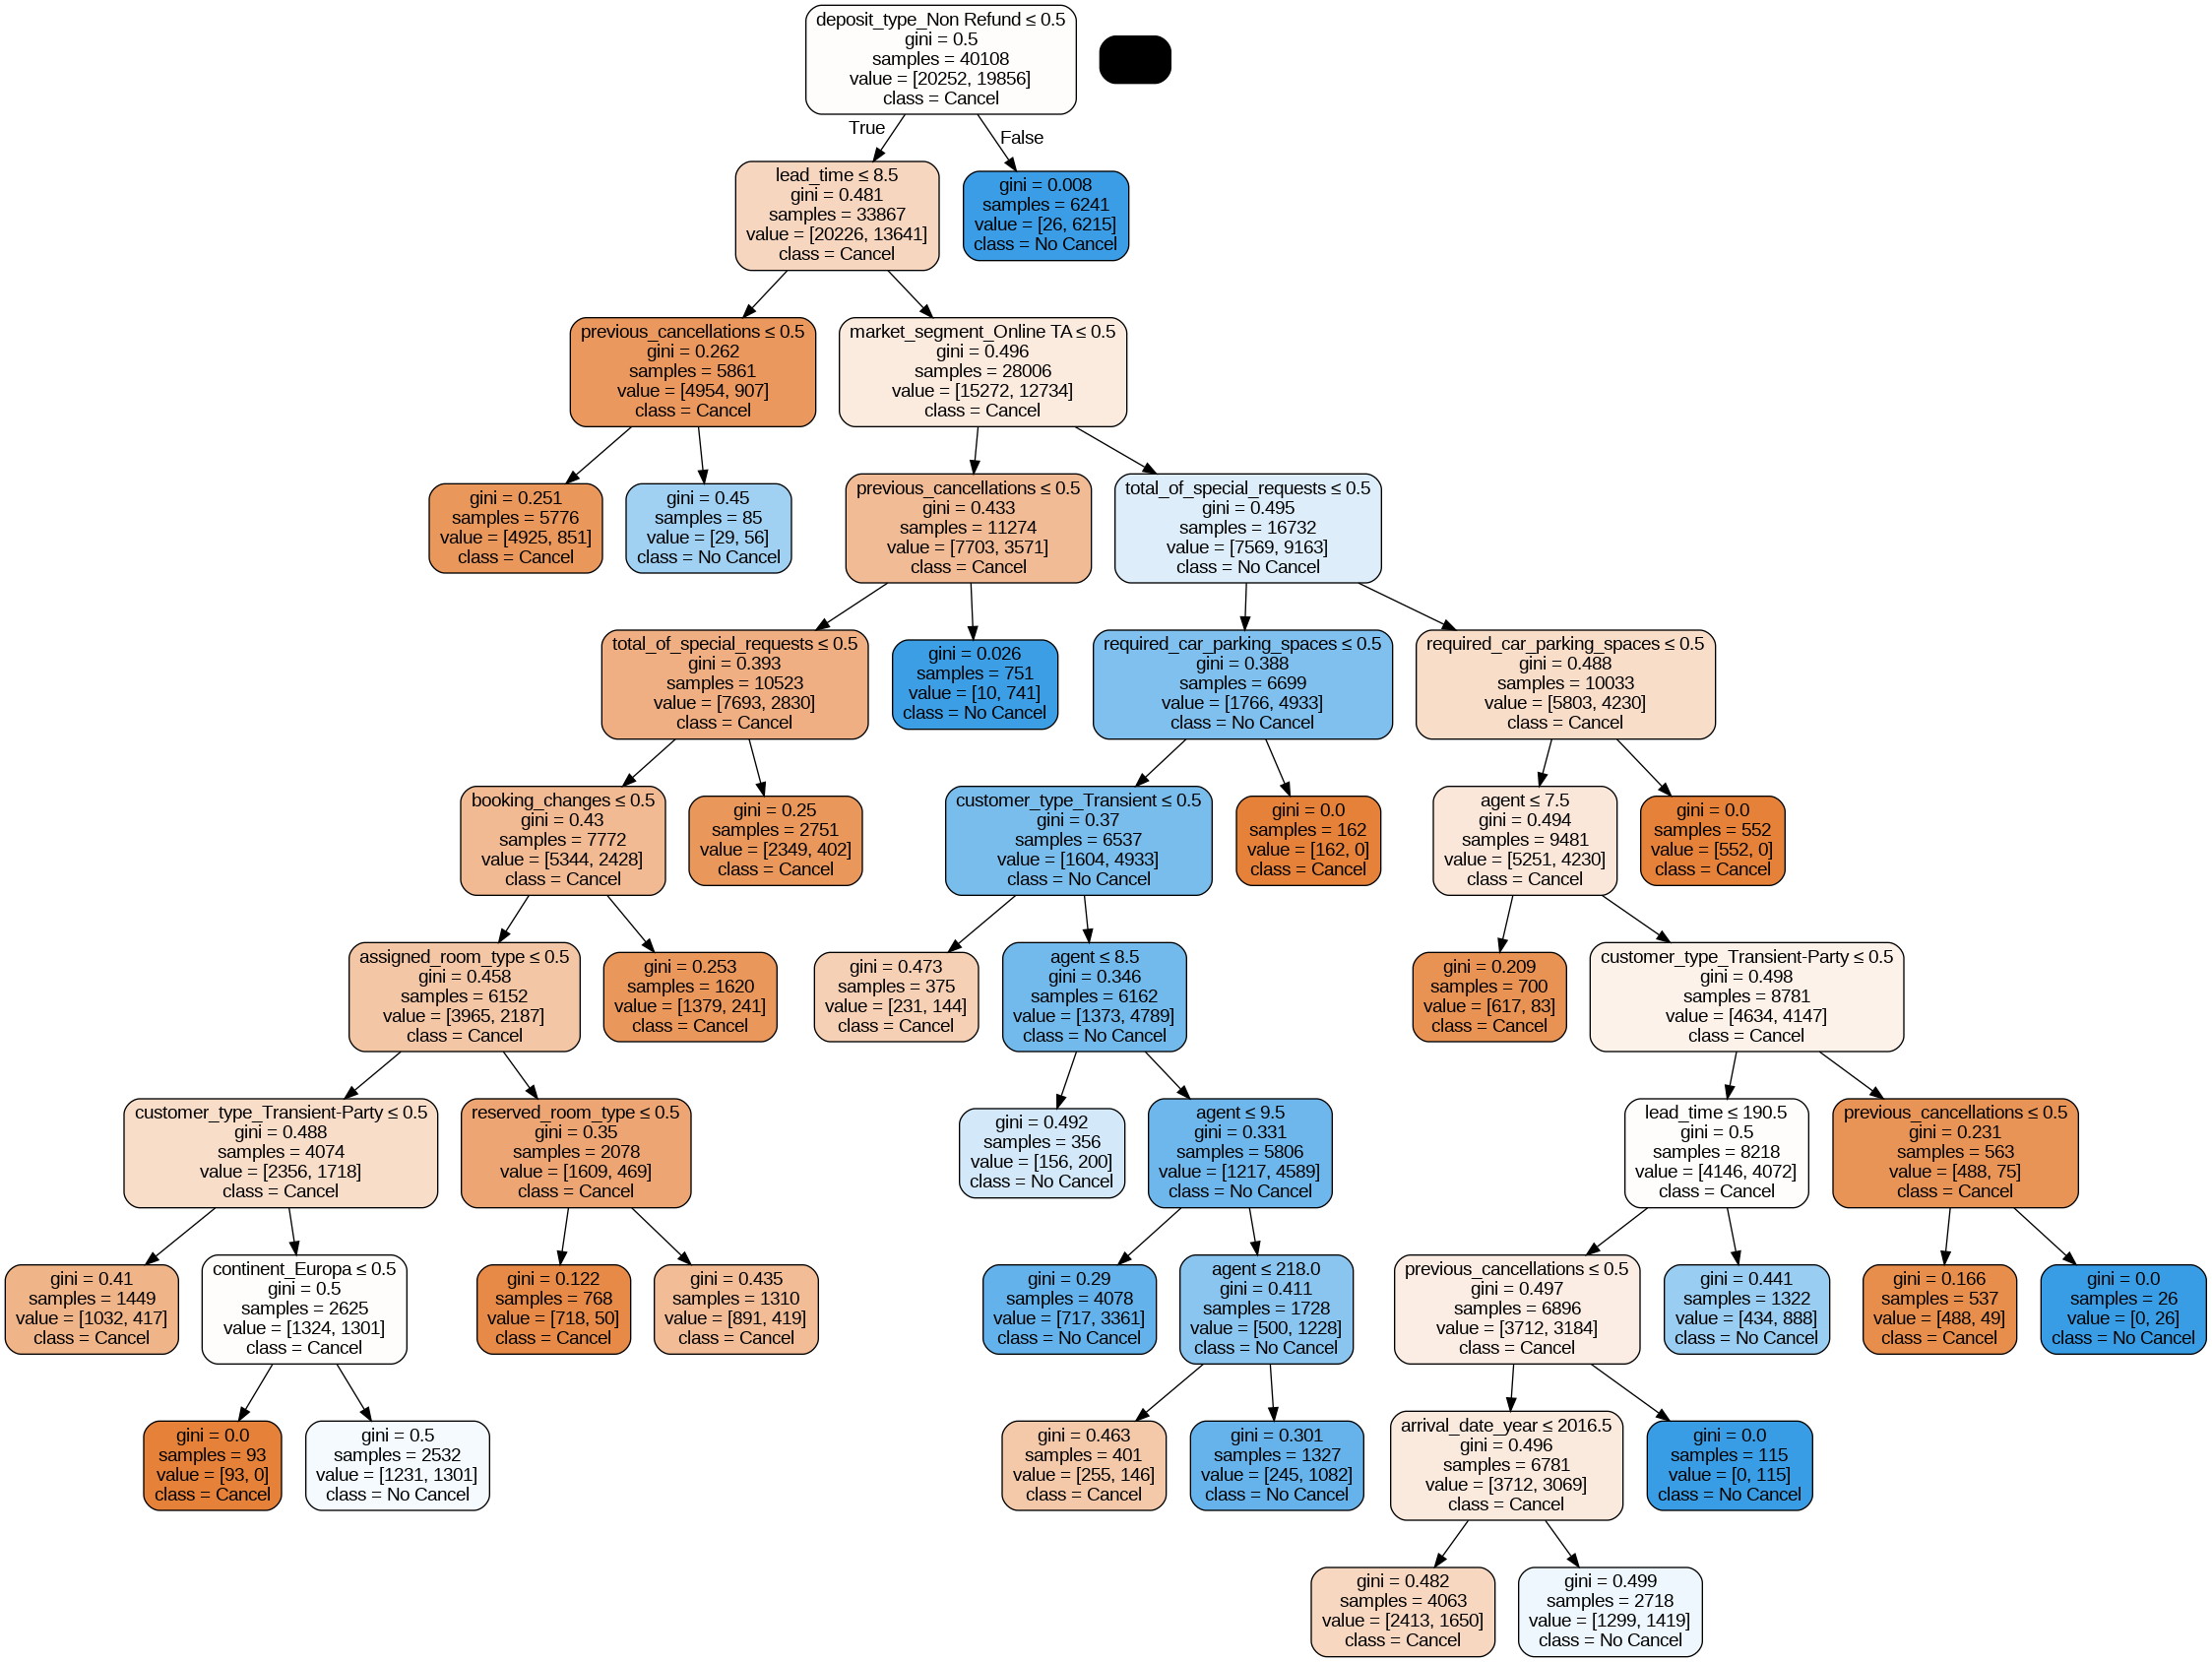

In [ ]:
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['Cancel','No Cancel'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      8646
           1       0.78      0.77      0.77      8544

    accuracy                           0.78     17190
   macro avg       0.78      0.78      0.78     17190
weighted avg       0.78      0.78      0.78     17190

F1-Score: 0.7788248981966259


Text(50.722222222222214, 0.5, 'True')

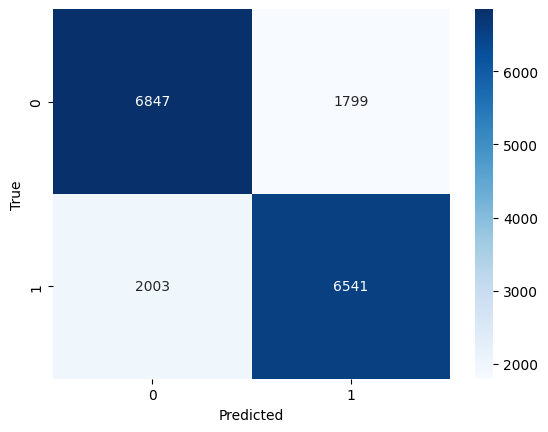

In [ ]:
y_pred = tree_model.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='micro')))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Es importante, a nosotros nos importa más predecir con exactitud las reservas canceladas (verdaderos positivos) y observamos que aumentó esta cifra levemente; la impureza de Gini tiende a aislar la clase más frecuente en su propia rama del árbol. Pero luego, para este modelo, en el resto de categorías se ve un desbalanceo. El accuracy de igual forma, se mantiene en 0.78, pero para la categoría cancelada baja tanto la precisión como el recall.

Encontramos un total de:

*   Verdaderos negativos hay 6847 casos. Las predicciones acerca de las reservas no canceladas hay un total de 6847 predicciones acertadas.
*   Verdaderos positivos hay 6541 casos. Las predicciones acerca de las reservas canceladas acertaron un total de 6541.
* Falsos positivos hay 1799 casos. Las predicciones acerca de reservas no canceladas fallaron en 1799 casos.
* Falsos negativos hay 2003 casos. Las predicciones sobre reservas canceladas fallaron en 2003 casos.